## Preparación inicial

In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import io
from PIL import Image
import selenium
import polyline

In [2]:
xls = pd.ExcelFile('Prueba.xlsx')

In [3]:
sheet_names = xls.sheet_names
sheet_names

['Instrucciones', 'Glosario', 'PuntoPartida', 'PuntoLlegada', 'Siniestros']

In [4]:
punto_partida_df = pd.read_excel(xls, 'PuntoPartida')
punto_llegada_df = pd.read_excel(xls, 'PuntoLlegada')
siniestros_df = pd.read_excel(xls, 'Siniestros')

### Análisis Exploratorio
* Las coordenadas en ```punto_partida_df``` y ```punto_llegada_df``` están escritas en la notación *decimal degrees*.
* Las latitudes deben de ser números entre -90 y 90 grados.
* Las longitudes deben de ser números entre -180 y 180 grados.

#### punto_partida_df

In [5]:
punto_partida_df.dtypes

IDRuta                   object
NombreRuta               object
TipoUbicacion            object
Empresa                  object
HoraProgramadaSalida     object
Longitud                float64
Latitud                 float64
ValorMercancia            int64
IDConductor               int64
dtype: object

In [6]:
punto_partida_df.head()

,IDRuta,NombreRuta,TipoUbicacion,Empresa,HoraProgramadaSalida,Longitud,Latitud,ValorMercancia,IDConductor
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1
1,b2,Traslado de efectivo,Tienda,Empresa 1,09:00:00,-100.203823,25.663144,300000,1
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1


#### punto_llegada_df

In [7]:
punto_llegada_df.dtypes

IDRuta             object
NombreRuta         object
TipoUbicacion      object
Empresa            object
HoraSalida         object
Longitud           object
Latitud           float64
ValorMercancia      int64
IDConductor         int64
dtype: object

* La columna ```longitud``` debería ser de tipo ```float64```.

In [8]:
punto_llegada_df.head()

,IDRuta,NombreRuta,TipoUbicacion,Empresa,HoraSalida,Longitud,Latitud,ValorMercancia,IDConductor
0,a1,Relleno de Inventario,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,150000,1
1,b2,Traslado de efectivo,Banco,Banco 1,08:58:00,"-100.318156048963,",25.685163,300000,1
2,c3,Relleno de Inventario,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,1500000,1
3,d4,Relleno de Inventario,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,200000,1
4,e5,Traslado de efectivo,Banco,Banco 1,16:00:00,-100.318156,25.685163,123000,1


* Un valor en la columna *Longitud* no es un float valido pues termina con una coma.

In [9]:
# Remove any commas from the 'Longitud' column
punto_llegada_df['Longitud'] = punto_llegada_df['Longitud'].astype(str).str.replace(',', '', regex=False)

# Optionally, convert the cleaned column back to numeric if it's supposed to be numbers
punto_llegada_df['Longitud'] = pd.to_numeric(punto_llegada_df['Longitud'], errors='coerce')

In [10]:
punto_llegada_df.head()

,IDRuta,NombreRuta,TipoUbicacion,Empresa,HoraSalida,Longitud,Latitud,ValorMercancia,IDConductor
0,a1,Relleno de Inventario,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,150000,1
1,b2,Traslado de efectivo,Banco,Banco 1,08:58:00,-100.318156,25.685163,300000,1
2,c3,Relleno de Inventario,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,1500000,1
3,d4,Relleno de Inventario,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,200000,1
4,e5,Traslado de efectivo,Banco,Banco 1,16:00:00,-100.318156,25.685163,123000,1


In [11]:
punto_llegada_df.dtypes

IDRuta             object
NombreRuta         object
TipoUbicacion      object
Empresa            object
HoraSalida         object
Longitud          float64
Latitud           float64
ValorMercancia      int64
IDConductor         int64
dtype: object

#### siniestros_df

In [12]:
siniestros_df.dtypes

FolioSiniestro       int64
Evento              object
Subtipo             object
UnidadOperativa     object
IDTienda           float64
IDVehiculo         float64
ValorPerdido         int64
Latitud            float64
Longitud           float64
dtype: object

In [13]:
siniestros_df.head()

,FolioSiniestro,Evento,Subtipo,UnidadOperativa,IDTienda,IDVehiculo,ValorPerdido,Latitud,Longitud
0,10001415,Robo,Con violencia,Tienda,4.0,NaN,84723,25.808908,-100.379278
1,10001213,Robo,Con violencia,Vehiculo,NaN,2.0,117041,25.799021,-100.386182
2,10001224,Robo,Sin violencia,Vehiculo,NaN,2.0,116400,25.797738,-100.381691
3,10001327,Robo,Sin violencia,Vehiculo,NaN,3.0,117888,25.786821,-100.379681
4,10001316,Robo,Con violencia,Tienda,3.0,NaN,73533,25.777179,-100.180762


## Calcular driving distance

In [14]:
rutas_df = pd.merge(
    punto_partida_df,
    punto_llegada_df,
    on=['IDRuta', 'NombreRuta', 'ValorMercancia', 'IDConductor'],
    suffixes=('Partida', 'Llegada')  # To differentiate columns if any aren't shared
)

# Show the merged DataFrame
rutas_df

,IDRuta,NombreRuta,TipoUbicacionPartida,EmpresaPartida,HoraProgramadaSalida,LongitudPartida,LatitudPartida,ValorMercancia,IDConductor,TipoUbicacionLlegada,EmpresaLlegada,HoraSalida,LongitudLlegada,LatitudLlegada
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1,Tienda,Empresa 1,10:03:00,-100.228542,25.550476
1,b2,Traslado de efectivo,Tienda,Empresa 1,09:00:00,-100.203823,25.663144,300000,1,Banco,Banco 1,08:58:00,-100.318156,25.685163
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1,Tienda,Empresa 3,14:10:00,-100.242414,25.664271
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1,Tienda,Empresa 2,11:00:19,-100.381548,25.664200
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1,Banco,Banco 1,16:00:00,-100.318156,25.685163


In [15]:
def get_driving_distance(start_coords, end_coords):
    # Unpack the coordinates
    start_lon, start_lat = start_coords
    end_lon, end_lat = end_coords

    # OSRM API endpoint
    url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}?overview=false"

    # Send the request to OSRM API
    response = requests.get(url)
    
    # Parse the JSON response
    data = response.json()

    if data and 'routes' in data:
        # Extract the distance in meters
        distance = data['routes'][0]['distance']
        # Extract the duration in seconds
        duration = data['routes'][0]['duration']
        return distance, duration
    else:
        return None, None

# Example usage with coordinates from your spreadsheet
start_coords = (-100.31654, 25.6963)  # Starting point coordinates
end_coords = (-100.228542, 25.550476)  # Destination point coordinates

distance, duration = get_driving_distance(start_coords, end_coords)
print(f"Driving Distance: {distance} meters, Duration: {duration} seconds")

Driving Distance: 20482.1 meters, Duration: 1054.3 seconds


In [16]:
# Apply function to each row in rutas_df
def apply_driving_distance(row):
    # Extract the starting and ending coordinates
    start_coords = (row['LongitudPartida'], row['LatitudPartida'])
    end_coords = (row['LongitudLlegada'], row['LatitudLlegada'])
    
    # Get the driving distance and duration
    distance, duration = get_driving_distance(start_coords, end_coords)
    
    return pd.Series([distance, duration], index=['DistanceMeters', 'DurationSeconds'])

# Apply the function to every row and store results in new columns
rutas_df[['DistanceMeters', 'DurationSeconds']] = rutas_df.apply(apply_driving_distance, axis=1)

In [17]:
rutas_df

,IDRuta,NombreRuta,TipoUbicacionPartida,EmpresaPartida,HoraProgramadaSalida,LongitudPartida,LatitudPartida,ValorMercancia,IDConductor,TipoUbicacionLlegada,EmpresaLlegada,HoraSalida,LongitudLlegada,LatitudLlegada,DistanceMeters,DurationSeconds
0,a1,Relleno de Inventario,Bodega,Empresa 1,10:00:00,-100.316540,25.696300,150000,1,Tienda,Empresa 1,10:03:00,-100.228542,25.550476,20482.1,1054.3
1,b2,Traslado de efectivo,Tienda,Empresa 1,09:00:00,-100.203823,25.663144,300000,1,Banco,Banco 1,08:58:00,-100.318156,25.685163,13728.1,1052.4
2,c3,Relleno de Inventario,Bodega,Empresa 3,14:00:00,-100.145293,25.788839,1500000,1,Tienda,Empresa 3,14:10:00,-100.242414,25.664271,23049.7,1570.3
3,d4,Relleno de Inventario,Bodega,Empresa 2,11:00:00,-100.367606,25.814914,200000,1,Tienda,Empresa 2,11:00:19,-100.381548,25.664200,25139.5,1597.2
4,e5,Traslado de efectivo,Tienda,Empresa 3,15:00:00,-100.421277,25.744508,123000,1,Banco,Banco 1,16:00:00,-100.318156,25.685163,14105.0,928.2


## Visualizar ```siniestros_df```

### Distribución de tipos de evento

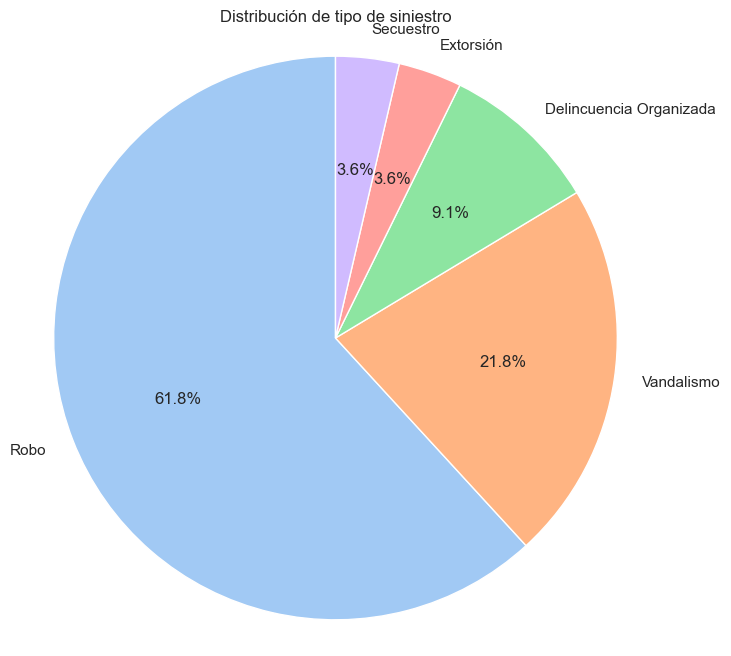

In [18]:
# Apply Seaborn theme to Matplotlib plots
sns.set_theme()

# Assuming 'TipoSiniestro' is the column that contains the siniestro types
# Count the occurrences of each type
siniestro_counts = siniestros_df['Evento'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))  # Optional: Set the figure size
plt.pie(siniestro_counts, labels=siniestro_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title('Distribución de tipo de siniestro')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()


### Distribución de valor perdido

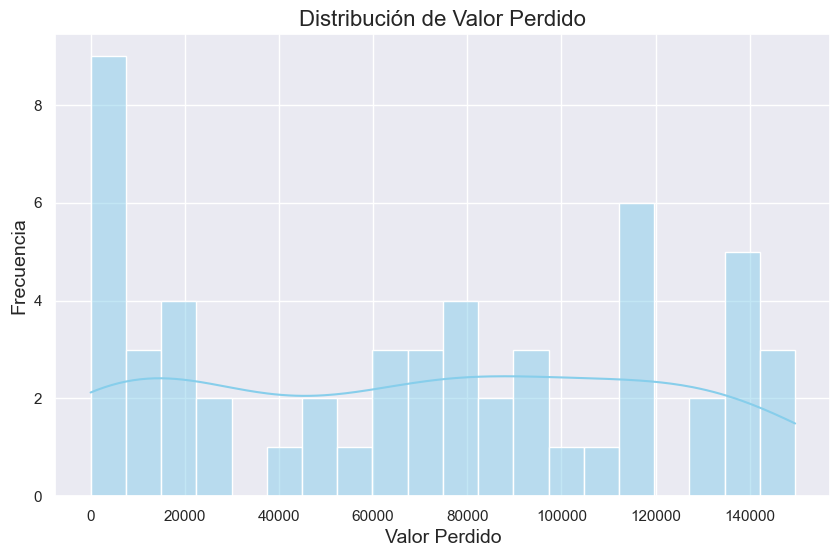

In [19]:
# Set Seaborn theme for better aesthetics
sns.set_theme()

# Plot the histogram of "Valor Perdido"
plt.figure(figsize=(10, 6))  # Optional: Set figure size
sns.histplot(siniestros_df['ValorPerdido'], bins=20, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribución de Valor Perdido', fontsize=16)
plt.xlabel('Valor Perdido', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Show the plot
plt.show()

### Visualización geográfica de siniestros

* Crear un diccionario de tipos de eventos con color correspondiente.

In [20]:
eventos = siniestros_df.Evento.unique()
eventos

array(['Robo', 'Vandalismo', 'Extorsión', 'Secuestro',
       'Delincuencia Organizada'], dtype=object)

In [21]:
colors = ['blue', 'green', 'red', 'yellow', 'purple']

In [22]:
event_colors = dict(zip(eventos, colors))
event_colors

{'Robo': 'blue',
 'Vandalismo': 'green',
 'Extorsión': 'red',
 'Secuestro': 'yellow',
 'Delincuencia Organizada': 'purple'}

* Crear mapa usando ```folium```. Creamos un mapa base que tenga como su centro el promedio de las coordenadas de los siniestros.

In [23]:
# Create a base map centered around the average coordinates
m = folium.Map(location=[siniestros_df['Latitud'].mean(), siniestros_df['Longitud'].mean()], zoom_start=11, zoom_control=False)

# Loop through the DataFrame to add markers for each event
for index, row in siniestros_df.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=row['Evento'],  # This shows the event type on marker click
        icon=folium.Icon(color=event_colors.get(row['Evento'], 'gray'))  # Default to gray if type not found
    ).add_to(m)

/var/folders/gf/8nm7hnt56930dgzv4ygl2z8w0000gn/T/ipykernel_6998/1270950267.py:9: UserWarning: color argument of Icon should be one of: {'black', 'darkpurple', 'orange', 'lightgreen', 'darkred', 'darkblue', 'purple', 'pink', 'lightgray', 'red', 'blue', 'beige', 'white', 'green', 'gray', 'lightred', 'lightblue', 'cadetblue', 'darkgreen'}.
  icon=folium.Icon(color=event_colors.get(row['Evento'], 'gray'))  # Default to gray if type not found


* Crear una leyenda para poder distinguir los tipos de eventos en el mapa.

In [24]:
legend_items = ''.join(
    f'<li><span style="background-color: {color}; width: 20px; height: 20px; display: inline-block;"></span> {event_type}</li>'
    for event_type, color in event_colors.items()
)

legend_html = f'''
    <div style="position: fixed; 
                top: 10px; left: 10px; 
                width: 150px; height: auto; 
                z-index: 1000; 
                background-color: white; 
                border:2px solid grey; 
                border-radius:5px; 
                padding: 10px;">
        <h4 style="margin: 0;">Tipo de Evento</h4>
        <ul style="list-style-type:none; padding: 0;">
            {legend_items}
        </ul>
    </div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))


# Save the map to an HTML file
m.save('siniestros_map.html')

m

* Guardar imagen usando ```selenium```.

In [25]:
img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save('image.png')

## Visualizacón de rutas
* Para visualizar las rutas, continuar usando ```folium``` y obtener coordenadas de rutas utilizando *OSM*.

In [26]:
# Function to get route coordinates from OSRM
def get_route(start_coords, end_coords):
    url = f"http://router.project-osrm.org/route/v1/driving/{start_coords[1]},{start_coords[0]};{end_coords[1]},{end_coords[0]}?overview=full"
    response = requests.get(url)
    
    if response.status_code == 200:
        route = response.json()
        if route.get('routes'):  # Check if 'routes' exists
            # Decode the polyline to get a list of (lat, lon) tuples
            polyline_points = route['routes'][0]['geometry']
            return polyline.decode(polyline_points)  # Decode the polyline
        else:
            print("No routes found in the response:", route)  # Debugging output
    else:
        print(f"Error {response.status_code}: {response.text}")  # Print error message for debugging
    
    return None

In [27]:
# Create a base map centered around the average coordinates of the routes
average_lat = (rutas_df['LatitudPartida'].mean() + rutas_df['LatitudLlegada'].mean()) / 2
average_lon = (rutas_df['LongitudPartida'].mean() + rutas_df['LongitudLlegada'].mean()) / 2
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

m

In [33]:
# Redefinir colors para re-ejecutar celda sin necesidad de ejecutar celdas anteriores
colors = ['blue', 'green', 'red', 'black', 'purple']

# Loop through the rutas_df to add markers and draw routes
for index, row in rutas_df.iterrows():
    color = colors.pop()
    
    start_coords = (row['LatitudPartida'], row['LongitudPartida'])
    end_coords = (row['LatitudLlegada'], row['LongitudLlegada'])
    
    # Get the route coordinates from OSRM
    route_coords = get_route(start_coords, end_coords)

    if route_coords:
        # Add a marker for the starting point
        folium.Marker(
            location=start_coords,
            popup=f"Ruta: {row['IDRuta']} - Salida",
            icon=folium.Icon(color=color)
        ).add_to(m)
        
        # Add a marker for the ending point
        folium.Marker(
            location=end_coords,
            popup=f"Ruta: {row['IDRuta']} - Llegada",
            icon=folium.Icon(color=color)
        ).add_to(m)
        
        # Draw a line using the route coordinates
        folium.PolyLine(locations=route_coords, color=color).add_to(m)

# Save the map to an HTML file
m.save('rutas_map_street.html')

# Display the map
m

## Visualizar rutas y siniestros en conjunto

In [34]:
eventos = siniestros_df.Evento.unique()
eventos

array(['Robo', 'Vandalismo', 'Extorsión', 'Secuestro',
       'Delincuencia Organizada'], dtype=object)

In [35]:
colors = ['blue', 'green', 'red', 'yellow', 'purple']

In [36]:
event_colors = dict(zip(eventos, colors))
event_colors

{'Robo': 'blue',
 'Vandalismo': 'green',
 'Extorsión': 'red',
 'Secuestro': 'yellow',
 'Delincuencia Organizada': 'purple'}

* Crear mapa usando ```folium```. Creamos un mapa base que tenga como su centro el promedio de las coordenadas de los siniestros.

In [41]:
# Create a base map centered around the average coordinates
m = folium.Map(location=[siniestros_df['Latitud'].mean(), siniestros_df['Longitud'].mean()], zoom_start=11, zoom_control=False)

# Loop through the DataFrame to add markers for each event
for index, row in siniestros_df.iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=row['Evento'],  # This shows the event type on marker click
        icon=folium.Icon(color=event_colors.get(row['Evento'], 'gray'), icon='glyphicon glyphicon-warning-sign')  # Default to gray if type not found
    ).add_to(m)

/var/folders/gf/8nm7hnt56930dgzv4ygl2z8w0000gn/T/ipykernel_6998/3259709489.py:9: UserWarning: color argument of Icon should be one of: {'black', 'darkpurple', 'orange', 'lightgreen', 'darkred', 'darkblue', 'purple', 'pink', 'lightgray', 'red', 'blue', 'beige', 'white', 'green', 'gray', 'lightred', 'lightblue', 'cadetblue', 'darkgreen'}.
  icon=folium.Icon(color=event_colors.get(row['Evento'], 'gray'), icon='glyphicon glyphicon-warning-sign')  # Default to gray if type not found


* Crear una leyenda para poder distinguir los tipos de eventos en el mapa.

In [42]:
legend_items = ''.join(
    f'<li><span style="background-color: {color}; width: 20px; height: 20px; display: inline-block;"></span> {event_type}</li>'
    for event_type, color in event_colors.items()
)

legend_html = f'''
    <div style="position: fixed; 
                top: 10px; left: 10px; 
                width: 150px; height: auto; 
                z-index: 1000; 
                background-color: white; 
                border:2px solid grey; 
                border-radius:5px; 
                padding: 10px;">
        <h4 style="margin: 0;">Tipo de Evento</h4>
        <ul style="list-style-type:none; padding: 0;">
            {legend_items}
        </ul>
    </div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))


# Save the map to an HTML file
m.save('siniestros_map.html')

m

In [44]:
# Redefinir colors para re-ejecutar celda sin necesidad de ejecutar celdas anteriores
colors = ['lightblue', 'darkgreen', 'red', 'black', 'purple']

# Loop through the rutas_df to add markers and draw routes
for index, row in rutas_df.iterrows():
    color = colors.pop()
    
    start_coords = (row['LatitudPartida'], row['LongitudPartida'])
    end_coords = (row['LatitudLlegada'], row['LongitudLlegada'])
    
    # Get the route coordinates from OSRM
    route_coords = get_route(start_coords, end_coords)

    if route_coords:
        # Add a marker for the starting point
        folium.Marker(
            location=start_coords,
            popup=f"Ruta: {row['IDRuta']} - Salida",
            icon=folium.Icon(color=color, icon='glyphicon glyphicon-map-marker')
        ).add_to(m)
        
        # Add a marker for the ending point
        folium.Marker(
            location=end_coords,
            popup=f"Ruta: {row['IDRuta']} - Llegada",
            icon=folium.Icon(color=color, icon='glyphicon glyphicon-map-marker')
        ).add_to(m)
        
        # Draw a line using the route coordinates
        folium.PolyLine(locations=route_coords, color=color).add_to(m)

# Save the map to an HTML file
m.save('rutas_map_street.html')

# Display the map
m